In [1]:


import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import copy
from sklearn.preprocessing import StandardScaler
import scipy.special as special
import scipy.sparse as sp


import os


import tensorflow as tf
#import tensorflow_addons as tfa
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, GRU, Input
from tensorflow.keras.optimizers import SGD, Adam


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Dense, LeakyReLU, GRU, Concatenate, Reshape, Softmax, Attention
from tensorflow.keras import activations
from tensorflow.keras.models import Model
#from keras.layers import LeakyReLU

from spektral.layers import  GCSConv, DiffusionConv, GATConv, ARMAConv, GCNConv

from tensorflow.keras.regularizers import l2

Using TensorFlow backend.


In [2]:
def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=False, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    data_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        data_list.append(time_in_day)
    if add_day_in_week:
        day_in_week = np.zeros(shape=(num_samples, num_nodes, 7))
        day_in_week[np.arange(num_samples), :, df.index.dayofweek] = 1
        data_list.append(day_in_week)

    data = np.concatenate(data_list, axis=-1)
    # epoch_len = num_samples + min(x_offsets) - max(y_offsets)
    x, y = [], []
    # t is the index of the last observation.
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y



def plot_loss(dic):
    plt.figure(figsize=(12,5))
    #plt.subplot(1, 2, 1)
    plt.plot(dic['loss'], label='Training loss ')
    plt.plot(dic['val_loss'], label='Validation loss ')
    plt.legend(frameon=False)
    plt.title('train and validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


    
def MSE(original, imputed):
    # calculate Mean Squared Error
    return np.square(original-imputed).mean()

def MPE(y_true, y_pred, threshold=0.1):
    v = np.copy(y_true)
    np.place(v, v==0, threshold)
    #v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return np.mean(diff, axis=-1).mean()

"""
def R_squared(original, predicted):
    Differ = np.square(original-predicted)
    m = np.mean(original) 
    denom = np.square(original - m)
    R_sq = 1 - ((Differ.sum())/denom.sum())
    return R_sq
"""
def R_squared(original, predicted):
    Differ = np.square(original-predicted)
    #m = np.mean(original) 
    denom = np.square(original)
    R_sq = 1 - ((Differ.sum())/denom.sum())
    return R_sq

def Get_performance(Y_true, Y_pred): 
    print ("R2 : ", np.round(R_squared(Y_true, Y_pred), 4))
    print ("MSE",  np.round(MSE(Y_true, Y_pred), 4))
    print ("MPE", np.round(MPE(Y_true, Y_pred), 4))
    
    return (np.round(R_squared(Y_true, Y_pred), 4), np.round(MSE(Y_true, Y_pred), 4), np.round(MPE(Y_true, Y_pred), 4)) 
        

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def mape(y_true, y_pred, threshold=0.1):
    v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return 100.0 * np.mean(diff, axis=-1).mean()

def get_metrics(y, yp):
    return {
        "rmse": np.round(rmse(y, yp), 4),
        "mae": np.round(mae(y, yp), 4),
        "mape": np.round(mape(y, yp),4),
        #"MPE": np.round(MPE(y, yp), 4),
        #"R2": np.round(R_squared(y, yp),4)
        
    }


In [3]:


# Load and preview dataset
import datetime
import pandas as pd
import numpy as np

In [4]:
Synthetic = pd.read_csv('Synthetic_Data.csv', parse_dates=['date'])
Synthetic['ID'] = Synthetic.groupby(["country", "Series", 'S_type']).ngroup()
Synthetic.set_index('date', inplace =True)

Synthetic['ret'] = Synthetic.groupby('ID')['value'].pct_change()
Synthetic.dropna(inplace= True)

In [5]:
Synthetic_char = Synthetic[['country_gdp_factor', 'weekend_boost_factor','product_linear_trend','random_seris_type',
                            'white_noise', 'holiday_trend_factor', 'eu_industry_product_factor', 'product_seasonal_trend_factor',
                            'random_series_factor', 'wavelength', 'amplitude', 'phase', 'ID']]

Synthetic_char= Synthetic_char.reset_index().set_index(['date', 'ID'])

Synthetic_ret = Synthetic[['ID', 'ret']].pivot(columns='ID', values='ret')
Synthetic_val = Synthetic[['ID', 'value']].pivot(columns='ID', values='value')

In [8]:
n_day = len(Synthetic_char.groupby('date').size())
n_firms = len(Synthetic_char.groupby('ID').size())

In [9]:
#how many time lag I wanna use
n_lag = 36
#how many time period I wanna predict
n_forward = 1

x_offsets = np.sort(np.arange(-n_lag+1, 1, 1))
y_offsets = np.sort(np.arange(1, n_forward+1, 1))

In [10]:
x, y = generate_graph_seq2seq_io_data(
    Synthetic_ret,
    x_offsets=x_offsets,
    y_offsets=y_offsets,
    add_time_in_day=False,
    add_day_in_week=False,
    )

In [11]:
#Do Standardization
#standardization
scaler = StandardScaler()
#scaler.fit(data)
data_stand = scaler.fit_transform(Synthetic_char)
#data_stand = pd.DataFrame(data_stand, index=data.index,  columns=data.columns)  
features = data_stand.reshape(n_day, n_firms, Synthetic_char.shape[1])
features = features[n_lag-1:-n_forward,:,:]

In [12]:
x = np.transpose(x, (0, 2, 1, 3))
y = np.transpose(y, (0, 2, 1, 3))

#reshape to made three dimensional tensor
x = x.reshape(x.shape[0],x.shape[1],x.shape[2] )
y = y.reshape(y.shape[0],y.shape[1],y.shape[2] )

#x = np.transpose(x, (0, 2, 1))
#y = np.transpose(y, (0, 2, 1))



x = x.astype('float32')
y = y.astype('float32')

In [13]:
AdPos = np.empty([x.shape[0], x.shape[1], x.shape[1]])
AdNeg = np.empty([x.shape[0], x.shape[1], x.shape[1]])

for i in range(0, x.shape[0]):
    aa = np.corrcoef(x[i],rowvar=True)
    P_val =  np.abs((aa*np.sqrt(n_lag-2))/(np.sqrt(1-np.square(aa))))
    P_val  = np.nan_to_num(P_val, nan=0.0, posinf=0, neginf=0)
    ab = n_lag/2 - 1
    P_val = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(aa))))
    P_val = np.nan_to_num(P_val, nan=0.0, posinf=0, neginf=0)
    P_val  = np.where(P_val>0.05, 0, 1)
    
    Adjac = aa*P_val
    #adj_matrix[i] = P_val 
    
    AdPos[i] =  np.where(Adjac > 0,1,0 )
    AdNeg[i] =  np.where(Adjac < 0,1,0 )

/home/ajim/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [23]:
Adj = np.ones((1059, 50, 50))

In [24]:
x.shape

(1059, 50, 36)

In [25]:
x_train = x[:600,:,:]
y_train = y[:600,:,:]



x_val = x[600:800,:,:]
y_val = y[600:800,:,:]


x_test = x[800:,:,:]
y_test = y[800:,:,:]


features_train  = features[:600,:,:]
features_val  =   features[600:800,:,:]
features_test  =  features[800:,:,:]



adj_train = Adj[:600,:,:]
adj_val = Adj[600:800,:,:]
adj_test = Adj[800:,:,:]



In [26]:
learning_rate = 0.001
batch_size =24
epochs = 100
seed = 42
verbose = 1

In [27]:
tf.keras.backend.clear_session()

In [28]:
## Define Model

inputs_ret = Input(shape=(x.shape[1], x.shape[2], ))
inputs_feat = Input(shape=(features.shape[1], features.shape[2], ))
inputs_adj = Input(shape=(features.shape[1],features.shape[1], ))

#inputs_3 = Input(shape=(data_shape[1],k, ))

GAT_output_P, Att_weights_P =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=True, 
                                   activation='relu', use_bias=False)([inputs_ret, inputs_adj])
Att_weights_P = tf.math.reduce_mean(Att_weights_P, axis=2)

GAT_output_P_2 =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=False, 
                        activation='relu', use_bias=True)([inputs_feat, inputs_adj])


con_out_P_2 = Concatenate(axis=-1)([ GAT_output_P_2, GAT_output_P])

dense_out = Dense(8, activation='linear')(con_out_P_2)
dense_out = Dropout(0.2)(dense_out)
outputs = Dense(1)(dense_out)




In [29]:

model = Model(inputs=[inputs_ret, inputs_feat, inputs_adj], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=["mae", "mape"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 12)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50, 50)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 50, 36)]     0                                            
__________________________________________________________________________________________________
gat_conv_1 (GATConv)            (None, 50, 64)       896         input_2[0][0]                    
                                                                 input_3[0][0]         

In [30]:
hists = model.fit(x= [x_train, features_train, adj_train],
                  y= y_train, verbose=verbose, epochs=500,
                  batch_size=batch_size, #validation_split=0.1, 
                  validation_data=([x_val, features_val, adj_val], y_val),
                  callbacks=[EarlyStopping(#monitor="val_mean_absolute_error", 
                      monitor="val_loss", patience=20, restore_best_weights=True)], )

Epoch 1/500
25/25 [==============================] - 0s 19ms/step - mape: 948.1227 - loss: 0.0194 - mae: 0.1047 - val_loss: 0.0074 - val_mape: 329.7380 - val_mae: 0.0683
Epoch 2/500
25/25 [==============================] - 0s 11ms/step - mape: 500.0723 - loss: 0.0082 - mae: 0.0717 - val_loss: 0.0062 - val_mape: 392.1599 - val_mae: 0.0627
Epoch 3/500
25/25 [==============================] - 0s 11ms/step - mape: 488.4259 - loss: 0.0069 - mae: 0.0660 - val_loss: 0.0059 - val_mape: 358.8492 - val_mae: 0.0613
Epoch 4/500
25/25 [==============================] - 0s 11ms/step - mape: 483.5336 - loss: 0.0066 - mae: 0.0644 - val_loss: 0.0057 - val_mape: 342.0595 - val_mae: 0.0604
Epoch 5/500
25/25 [==============================] - 0s 11ms/step - mape: 435.7394 - loss: 0.0063 - mae: 0.0635 - val_loss: 0.0057 - val_mape: 338.9361 - val_mae: 0.0600
Epoch 6/500
25/25 [==============================] - 0s 11ms/step - mape: 409.7964 - loss: 0.0063 - mae: 0.0632 - val_loss: 0.0056 - val_mape: 330.996

Epoch 49/500
25/25 [==============================] - 0s 11ms/step - mape: 389.0603 - loss: 0.0056 - mae: 0.0596 - val_loss: 0.0055 - val_mape: 356.0229 - val_mae: 0.0587
Epoch 50/500
25/25 [==============================] - 0s 11ms/step - mape: 360.4140 - loss: 0.0056 - mae: 0.0595 - val_loss: 0.0055 - val_mape: 354.6846 - val_mae: 0.0588
Epoch 51/500
25/25 [==============================] - 0s 11ms/step - mape: 419.0982 - loss: 0.0056 - mae: 0.0596 - val_loss: 0.0055 - val_mape: 338.6541 - val_mae: 0.0589
Epoch 52/500
25/25 [==============================] - 0s 11ms/step - mape: 396.6810 - loss: 0.0056 - mae: 0.0597 - val_loss: 0.0055 - val_mape: 355.0750 - val_mae: 0.0587
Epoch 53/500
25/25 [==============================] - 0s 11ms/step - mape: 416.3093 - loss: 0.0056 - mae: 0.0596 - val_loss: 0.0055 - val_mape: 356.2129 - val_mae: 0.0588
Epoch 54/500
25/25 [==============================] - 0s 11ms/step - mape: 378.6434 - loss: 0.0056 - mae: 0.0594 - val_loss: 0.0055 - val_mape: 3

Epoch 97/500
25/25 [==============================] - 0s 11ms/step - mape: 374.5500 - loss: 0.0042 - mae: 0.0516 - val_loss: 0.0040 - val_mape: 307.4622 - val_mae: 0.0498
Epoch 98/500
25/25 [==============================] - 0s 11ms/step - mape: 479.4636 - loss: 0.0042 - mae: 0.0517 - val_loss: 0.0039 - val_mape: 305.3140 - val_mae: 0.0494
Epoch 99/500
25/25 [==============================] - 0s 11ms/step - mape: 366.6324 - loss: 0.0042 - mae: 0.0513 - val_loss: 0.0040 - val_mape: 292.1496 - val_mae: 0.0497
Epoch 100/500
25/25 [==============================] - 0s 11ms/step - mape: 382.8343 - loss: 0.0042 - mae: 0.0516 - val_loss: 0.0039 - val_mape: 321.1652 - val_mae: 0.0493
Epoch 101/500
25/25 [==============================] - 0s 11ms/step - mape: 411.8847 - loss: 0.0042 - mae: 0.0512 - val_loss: 0.0039 - val_mape: 342.5869 - val_mae: 0.0492
Epoch 102/500
25/25 [==============================] - 0s 11ms/step - mape: 348.3065 - loss: 0.0042 - mae: 0.0513 - val_loss: 0.0039 - val_mape

Epoch 145/500
25/25 [==============================] - 0s 11ms/step - mape: 375.3748 - loss: 0.0039 - mae: 0.0499 - val_loss: 0.0038 - val_mape: 317.9837 - val_mae: 0.0483
Epoch 146/500
25/25 [==============================] - 0s 11ms/step - mape: 372.2294 - loss: 0.0039 - mae: 0.0497 - val_loss: 0.0037 - val_mape: 335.7043 - val_mae: 0.0482
Epoch 147/500
25/25 [==============================] - 0s 11ms/step - mape: 383.7101 - loss: 0.0039 - mae: 0.0496 - val_loss: 0.0037 - val_mape: 349.6010 - val_mae: 0.0481
Epoch 148/500
25/25 [==============================] - 0s 11ms/step - mape: 372.3092 - loss: 0.0039 - mae: 0.0497 - val_loss: 0.0037 - val_mape: 326.5302 - val_mae: 0.0481
Epoch 149/500
25/25 [==============================] - 0s 11ms/step - mape: 390.8699 - loss: 0.0039 - mae: 0.0496 - val_loss: 0.0037 - val_mape: 340.8369 - val_mae: 0.0481
Epoch 150/500
25/25 [==============================] - 0s 11ms/step - mape: 369.6276 - loss: 0.0039 - mae: 0.0497 - val_loss: 0.0037 - val_m

Epoch 193/500
25/25 [==============================] - 0s 11ms/step - mape: 414.7254 - loss: 0.0038 - mae: 0.0488 - val_loss: 0.0036 - val_mape: 340.6426 - val_mae: 0.0476
Epoch 194/500
25/25 [==============================] - 0s 11ms/step - mape: 362.1097 - loss: 0.0038 - mae: 0.0490 - val_loss: 0.0036 - val_mape: 339.0203 - val_mae: 0.0476
Epoch 195/500
25/25 [==============================] - 0s 11ms/step - mape: 399.3946 - loss: 0.0038 - mae: 0.0490 - val_loss: 0.0036 - val_mape: 340.4520 - val_mae: 0.0475
Epoch 196/500
25/25 [==============================] - 0s 11ms/step - mape: 400.5911 - loss: 0.0038 - mae: 0.0487 - val_loss: 0.0036 - val_mape: 348.5678 - val_mae: 0.0475
Epoch 197/500
25/25 [==============================] - 0s 11ms/step - mape: 407.7935 - loss: 0.0038 - mae: 0.0487 - val_loss: 0.0037 - val_mape: 375.2892 - val_mae: 0.0480
Epoch 198/500
25/25 [==============================] - 0s 11ms/step - mape: 391.0393 - loss: 0.0038 - mae: 0.0487 - val_loss: 0.0036 - val_m

Epoch 241/500
25/25 [==============================] - 0s 11ms/step - mape: 392.0127 - loss: 0.0037 - mae: 0.0482 - val_loss: 0.0036 - val_mape: 337.8888 - val_mae: 0.0473
Epoch 242/500
25/25 [==============================] - 0s 11ms/step - mape: 436.2894 - loss: 0.0037 - mae: 0.0480 - val_loss: 0.0036 - val_mape: 347.8208 - val_mae: 0.0473
Epoch 243/500
25/25 [==============================] - 0s 11ms/step - mape: 397.0668 - loss: 0.0037 - mae: 0.0482 - val_loss: 0.0036 - val_mape: 355.2025 - val_mae: 0.0473
Epoch 244/500
25/25 [==============================] - 0s 11ms/step - mape: 443.4710 - loss: 0.0037 - mae: 0.0483 - val_loss: 0.0036 - val_mape: 343.6446 - val_mae: 0.0473
Epoch 245/500
25/25 [==============================] - 0s 11ms/step - mape: 382.5080 - loss: 0.0037 - mae: 0.0483 - val_loss: 0.0036 - val_mape: 340.8487 - val_mae: 0.0473
Epoch 246/500
25/25 [==============================] - 0s 11ms/step - mape: 412.3257 - loss: 0.0037 - mae: 0.0481 - val_loss: 0.0036 - val_m

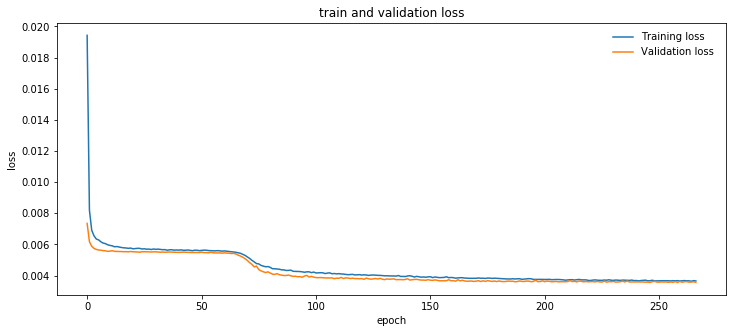

In [31]:
plot_loss(hists.history)

In [32]:
train_predicted = model.predict([x_train, features_train, adj_train])
get_metrics(y_train.flatten(), train_predicted.flatten())

{'mae': 0.0458, 'mape': 39.7896, 'rmse': 0.0576}

In [33]:
test_predicted = model.predict([x_test, features_test, adj_test])
get_metrics(y_test.flatten(), test_predicted.flatten())

{'mae': 0.0482, 'mape': 41.9682, 'rmse': 0.0605}

In [34]:
y_test_2  = y_test.reshape(y_test.shape[0],y_test.shape[1])
pred_test_2  =  test_predicted.reshape( test_predicted.shape[0], test_predicted.shape[1])

In [42]:
GAT_test_result = pd.DataFrame(pred_test_2, index = Synthetic_ret.index[-pred_test_2.shape[0]:], columns = Synthetic_ret.columns)

In [44]:
GAT_test_result.to_csv("GAT_test_result.csv")